In [2]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu

In [3]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=3, max_count=1000000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [4]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'

jac_exp = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_exp.cut_intervals]
df_exp_corr = pd.DataFrame(jac_exp.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [6]:
resolution_human = 1000
species = "human"
SRP_name = "aggregates"
resolution = "1kbp_raw"

exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/spr_cre/hic_gene_corr_inter_excluding_intra_chrom_pairs_hicexp.h5'

jac_exp = hm.hiCMatrix(exp_file_path)

all_genes = [x[3].decode() for x in jac_exp.cut_intervals]

f_m = jac_exp.matrix.toarray()
f_m = f_m + abs(f_m.min())
np.fill_diagonal(f_m, 1)
df_hic_corr = pd.DataFrame(f_m,  index=all_genes, columns = all_genes)



In [112]:
import pandas as pd, seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
sns.set(font="monospace")


DF_dism = df_hic_corr.max().max() - df_hic_corr  # distance matrix
DF_dism = DF_dism.to_numpy()
np.fill_diagonal(DF_dism, 0)
linkage_gene = hc.linkage(sp.distance.squareform(DF_dism), method='average')

In [14]:
DF_dism.min()

0.0

In [113]:
from scipy.cluster.hierarchy import fcluster, linkage
cluster_labels = fcluster(linkage_gene, 0.7, criterion='distance')

In [114]:
from collections import Counter
z = list(cluster_labels)
z = Counter(z)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 30.0)

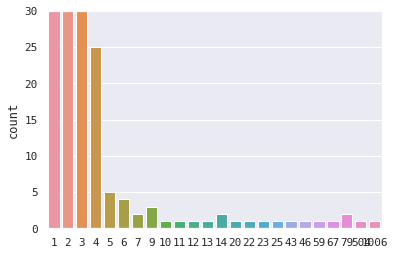

In [115]:
%matplotlib inline
import seaborn as sns
ax=sns.countplot(list(z.values()))
ax.set_ylim([0,30])

In [12]:
df_exp_clust = pd.DataFrame(cluster_labels ,  index=df_exp_corr.index.tolist())

df_exp_clust['label'] = df_exp_clust[0]

for clust, clust_len in zip(z.keys(), z.values()):
    if clust_len >= 2:
        
        print (clust, clust_len)
        df_exp_clust[clust] = [1 if x == clust else 0 for x in df_exp_clust['label'].tolist()]

446 21400
389 3
102 28
150 12
247 5
404 8
285 5
430 7
326 4
426 279
400 251
441 7
206 9
232 22
238 35
313 75
393 10
370 5
51 3
369 7
421 11
28 2
144 4
168 29
129 6
207 4
434 22
333 14
65 4
310 9
147 4
160 3
127 11
284 5
314 296
417 21
414 5
331 2
114 2
427 19
154 3
149 3
385 4
342 29
309 15
397 61
408 4
234 2
362 47
382 10
88 3
304 5
236 2
363 4
334 48
296 3
391 9
108 3
415 10
218 2
336 2
307 12
143 2
356 2
272 3
381 4
311 5
151 9
233 10
195 3
439 7
258 2
86 4
476 3
178 2
75 20
61 2
407 10
100 3
125 3
91 6
354 4
47 4
187 4
478 3
395 24
375 9
371 3
235 2
433 7
152 7
76 3
240 2
120 2
183 5
352 5
229 13
372 2
396 4
239 41
295 4
403 2
167 4
387 19
401 8
444 3
6 2
241 2
208 6
297 3
45 2
380 3
77 4
423 3
228 4
53 3
377 2
361 14
209 8
194 18
90 2
477 13
355 2
263 4
60 4
418 3
373 7
301 2
346 2
237 2
475 4
329 2
443 3
163 3
109 3
200 2
262 31
416 2
292 4
186 2
327 17
213 4
244 5
322 8
141 8
82 3
445 5
148 7
411 7
164 3
74 7
260 4
40 2
315 5
428 8
323 2
72 4
87 2
227 6
34 3
338 8
256 4
278 7
17

In [13]:
df_exp_clust = df_exp_clust.drop(['label', 0], axis=1)

(23465, 23465)
(23465, 254)
0.9995255121130314
0.0


<ipython-input-49-87b5e6212035>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


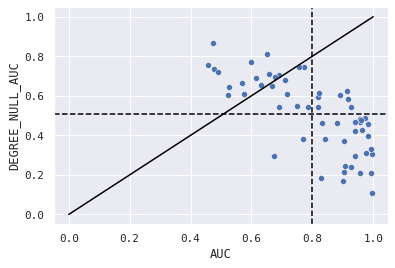

In [51]:
df_2d_jac, go_chrom  = run_egad(df_exp_clust, df_exp_corr)
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [ ]:
df_2d_jac, go_chrom  = run_egad(df_exp_clust, df_exp_corr)
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

(23465, 23465)
(23465, 350)
0.9971599038081033
3.632359968364085e-09


<ipython-input-3-87b5e6212035>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


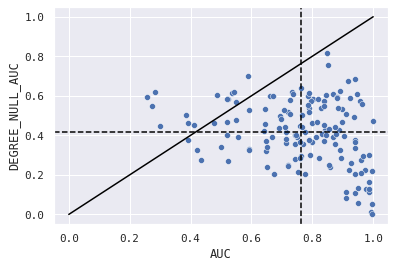

In [15]:
df_2d_jac, go_chrom  = run_egad(df_exp_clust, df_hic_corr)
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [17]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)
import joypy



In [18]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import pandas as pd

def fishers_exact(TP, TN, FP, FN):
    """Fishers exact for enrichment
	
	Input are values from a contigency tables
	
	Arguments:
		TP {int} -- Size of overlap
		TN {int} -- Size of both negative
		FP {int} -- Size of False Positive (Selected but not in query)
		FN {int} -- Size of False Negative (Not selected but in query)
	"""
    M = TP + TN + FP + FN
    n = TP + FN
    N = TP + FP
    #Have to use 1 - cdf to get correct density
    #We want selected P(TP or more)
    x = TP - 1
    return 1 - stats.hypergeom.cdf(x, M, n, N)

def enrichment(markerSet, referenceTerm):
    """Enrichment of a single gene set using Fisher's Exact
	
	Computes Fisher's Exact for a given marker set and reference term
	
	Arguments:
		markerSet {[type]} -- binary vector of gene set
		referenceTerm {[type]} -- binary vector of referenceTerm
	"""

    assert markerSet.shape[0] == referenceTerm.shape[
        0], 'Must have same list of all genes'
    TP = np.dot(markerSet, referenceTerm)
    FN = referenceTerm.sum() - TP
    FP = markerSet.sum() - TP
    TN = markerSet.shape[0] - (TP + FN + FP)
    return fishers_exact(TP, TN, FP, FN)

vector_exact = np.vectorize(
    lambda TP, TN, FP, FN: fishers_exact(TP, TN, FP, FN))

def enrichment_multi_reference(markers, reference):
    """Compute Enrichment between a list of markers and a list of references
	
	Computer enrichment, where markers is a list of cell-type markers and 
	the reference is all of GO
	
	Arguments:
		markers {np.array} -- Numpy 1-D array of float (0,1) for gene set membership
		reference {[type]} -- Numpy 2-D array of genes x terms of float (0,1) for term membership
	
	Returns:
		np.array -- 1-D array of BH adjusted P values
	"""
    assert markers.shape[0] == reference.shape[
        0], 'Must have same list of all genes'

    TP = markers @ reference
    FN = reference.sum(axis=0) - TP
    FP = np.sum(markers, axis=0) - TP
    TN = markers.shape[0] - (TP + FP + FN)
    p_val = vector_exact(TP, TN, FP, FN)
    p_adj = sm.stats.multipletests(p_val, method='fdr_bh')[1]
    return p_adj

def enrichment_df(markers_series, referenece_df):
    """Enrichment of Markers and Reference Network
    
    Computes enrichment of Markers and Reference Network from DataFrames
    
    Arguments:
        markers_series {pd.Series} -- Series of Marker Membership
        referenece_df {pd.DataFrame} -- DataFrame of Reference Gene List Memebership
    
    Returns:
        [type] -- [description]
    """
    shared_index = markers_series.index.intersection(referenece_df.index)
    padj = enrichment_multi_reference(
        markers_series.loc[shared_index].values.astype(float),
        referenece_df.loc[shared_index].values.astype(float))
    return pd.Series(padj, index=referenece_df.columns)

def enrich_multi_markers(markers_df, referenece_df):
    """Enrihcment of Multiple Markers Lists
    
    Apply's enrichment test to each marker list in marker df
    (Could Make a faster version if I fully vectorize the contingency table calculation)
    Arguments:
        markers_df {pd.DataFrame} -- genes x markers dataframe of membership
        referenece_df {pd.DataFrame} -- genes x terms dataframe of membership
    
    Returns:
        pd.DataFrame -- terms x marker names
    """
    return markers_df.apply(lambda x: enrichment_df(x, referenece_df))

In [19]:
        df = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)

        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])



In [35]:
go_table[GO_groups_ben['go_id'].tolist()]


KeyError: "['GO:0015979', 'GO:0030555', 'GO:0008565', 'GO:0005578', 'GO:0006461', 'GO:0007067', 'GO:0004871', 'GO:0005618', 'GO:0000988', 'GO:0043234', 'GO:0009579', 'GO:0001071', 'GO:0016023', 'go_id', 'GO:0009536'] not in index"

In [31]:
df_exp_clust



446  389  102  150  247  404  285  430  326  426  ...  266  \
ENSG00000278267    1    0    0    0    0    0    0    0    0    0  ...    0   
ENSG00000233750    1    0    0    0    0    0    0    0    0    0  ...    0   
ENSG00000268903    1    0    0    0    0    0    0    0    0    0  ...    0   
ENSG00000269981    1    0    0    0    0    0    0    0    0    0  ...    0   
ENSG00000241860    1    0    0    0    0    0    0    0    0    0  ...    0   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
ENSG00000155959    1    0    0    0    0    0    0    0    0    0  ...    0   
ENSG00000155961    1    0    0    0    0    0    0    0    0    0  ...    0   
ENSG00000155962    1    0    0    0    0    0    0    0    0    0  ...    0   
ENSG00000224533    1    0    0    0    0    0    0    0    0    0  ...    0   
ENSG00000185973    1    0    0    0    0    0    0    0    0    0  ...    0   

                 281  409  79   111  63   1    196  52   85   
ENSG00000278267    0    0    0    0    0    0    0    0    0  
ENSG00000233750    0    0    0    0    0    0    0    0    0  
ENSG00000268903    0    0    0    0    0    0    0    0    0  
ENSG00000269981    0    0    0    0    0    0    0    0    0  
ENSG00000241860    0    0    0    0    0    0    0    0    0  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  
ENSG00000155959    0    0    0    0    0    0    0    0    0  
ENSG00000155961    0    0    0    0    0    0    0    0    0  
ENSG00000155962    0    0    0    0    0    0    0    0    0  
ENSG00000224533    0    0    0    0    0    0    0    0    0  
ENSG00000185973    0    0    0    0    0    0    0    0    0  

[24243 rows x 350 columns]

In [43]:
go_term_enrich = enrich_multi_markers(df_exp_clust, go_table[list(set(GO_groups_ben['go_id'].tolist()).intersection(set(go_table.columns.tolist())))])



In [50]:
        GO_groups_des = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_description.txt', sep=":", names=["del","des"])
        GO_groups_ben = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/aug4.GOslim', names=["go_id"])
        GO_groups_type = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_process.txt', sep=" ", names=["del","type"])
        GO_groups = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther.txt', sep=" ", names=["del","go_id"])



In [64]:
        GO_groups.merge(GO_groups_des, left_on=GO_groups.index, right_on=GO_groups_des.index)

key_0 del_x       go_id del_y  \
0         0   id:  GO:0000003  name   
1         1   id:  GO:0000018  name   
2         2   id:  GO:0000027  name   
3         3   id:  GO:0000030  name   
4         4   id:  GO:0000038  name   
...     ...   ...         ...   ...   
3356   3356   id:  GO:2001242  name   
3357   3357   id:  GO:2001243  name   
3358   3358   id:  GO:2001251  name   
3359   3359   id:  GO:2001257  name   
3360   3360   id:  GO:2001259  name   

                                                    des  
0                                          reproduction  
1                       regulation of DNA recombination  
2                      ribosomal large subunit assembly  
3                          mannosyltransferase activity  
4          very long-chain fatty acid metabolic process  
...                                                 ...  
3356   regulation of intrinsic apoptotic signaling p...  
3357   negative regulation of intrinsic apoptotic si...  
3358     negative regulation of chromosome organization  
3359              regulation of cation channel activity  
3360     positive regulation of cation channel activity  

[3361 rows x 5 columns]

In [81]:
g3 = GO_groups_type.merge(GO_groups_des, left_on=GO_groups_type.index, right_on=GO_groups_des.index)

In [83]:
g3

key_0       del_x                type del_y  \
0         0  namespace:  biological_process  name   
1         1  namespace:  biological_process  name   
2         2  namespace:  biological_process  name   
3         3  namespace:  molecular_function  name   
4         4  namespace:  biological_process  name   
...     ...         ...                 ...   ...   
3366   3366  namespace:            external  name   
3367   3367  namespace:            external  name   
3368   3368  namespace:            external  name   
3369   3369  namespace:            external  name   
3370   3370  namespace:            external  name   

                                                des  
0                                      reproduction  
1                   regulation of DNA recombination  
2                  ribosomal large subunit assembly  
3                      mannosyltransferase activity  
4      very long-chain fatty acid metabolic process  
...                                             ...  
3366                                        part of  
3367                           positively regulates  
3368                                      regulates  
3369                                  starts_during  
3370                              term tracker item  

[3371 rows x 5 columns]

In [109]:
df_l = []
for each_clust in df_2d_jac[df_2d_jac['AUC'] >0.9].index.tolist():

    g1 = go_term_enrich[go_term_enrich<0.01][each_clust].dropna().reset_index()
    g2 = GO_groups.merge(g3[['type', 'des']], left_on=GO_groups.index, right_on=g3.index)
    
    df_l.append(g1.merge(g2, left_on='index', right_on='go_id')[['go_id', 'type', 'des']])
    
    

In [110]:
df2 = pd.concat(df_l)


In [111]:
df2[df2['type']!='cellular_component']



go_id                type  \
1  GO:0034641  biological_process   
2  GO:0022618  biological_process   
3  GO:0022607  biological_process   
4  GO:0006397  biological_process   
5  GO:0065003  biological_process   
6  GO:0003723  molecular_function   
0  GO:0022857  molecular_function   
1  GO:0048856  biological_process   
2  GO:0007155  biological_process   
3  GO:0050877  biological_process   
4  GO:0055085  biological_process   
5  GO:0000902  biological_process   
7  GO:0007267  biological_process   
8  GO:0034330  biological_process   
2  GO:0034641  biological_process   
3  GO:0022618  biological_process   
1  GO:0009790  biological_process   
2  GO:0003677  molecular_function   
3  GO:0048856  biological_process   
0  GO:0009790  biological_process   
1  GO:0003677  molecular_function   
3  GO:0048646  biological_process   
0  GO:0009790  biological_process   

                                                 des  
1       cellular nitrogen compound metabolic process  
2                 ribonucleoprotein complex assembly  
3                        cellular component assembly  
4                                    mRNA processing  
5                protein-containing complex assembly  
6                                        RNA binding  
0                 transmembrane transporter activity  
1                   anatomical structure development  
2                                      cell adhesion  
3                             nervous system process  
4                            transmembrane transport  
5                                 cell morphogenesis  
7                                cell-cell signaling  
8                         cell junction organization  
2       cellular nitrogen compound metabolic process  
3                 ribonucleoprotein complex assembly  
1                                 embryo development  
2                                        DNA binding  
3                   anatomical structure development  
0                                 embryo development  
1                                        DNA binding  
3   anatomical structure formation involved in mo...  
0                                 embryo development

In [89]:
go_term_enrich[go_term_enrich<0.05].dropna(axis=1, thresh=1)[446]

GO:0005634    7.975495e-11
GO:0006790             NaN
GO:0016491             NaN
GO:0051604             NaN
GO:0048870             NaN
                  ...     
GO:0006520             NaN
GO:0030198             NaN
GO:0006810             NaN
GO:0034655    3.539360e-04
GO:0003723    1.199755e-10
Name: 446, Length: 135, dtype: float64

index       110  key_0  del       go_id                type  \
0  GO:0009790  0.001179   1095  id:  GO:0009790  biological_process   
1  GO:0003677  0.011153    266  id:  GO:0003677  molecular_function   
2  GO:0005694  0.003241    445  id:  GO:0005694  cellular_component   
3  GO:0000228  0.001179     38  id:  GO:0000228  cellular_component   

                   des  
0   embryo development  
1          DNA binding  
2           chromosome  
3   nuclear chromosome

In [66]:
df_2d_jac[df_2d_jac['AUC'] >0.9]

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC        P_Value
102  0.976090      1059.624125         0.126543   2.040739e-16
430  0.940144      2113.834559         0.378659   3.208932e-05
238  0.910812      1003.738256         0.111233   1.940019e-17
284  0.947395      2972.152636         0.607366   7.230124e-04
314  0.923799      2968.709767         0.590080  6.405895e-133
363  0.940547      1403.568575         0.203700   1.667478e-03
311  0.958056      2942.198163         0.572327   2.577171e-04
354  0.998359      2426.064399         0.473850   2.408947e-03
375  0.941907       983.435591         0.108550   1.610753e-05
352  0.960543      1654.284066         0.273180   4.033217e-04
239  0.912240       856.861264         0.083131   9.424260e-20
209  0.939260      1948.482532         0.337052   2.731601e-05
262  0.940885      2087.549289         0.367623   9.353501e-18
213  0.905418      2270.522046         0.397212   2.448503e-03
227  0.909743      2652.651833         0.507787   1.768575e-03
338  0.926098      1691.524477         0.260508   1.806218e-04
256  0.941364      3335.564189         0.683858   8.576066e-03
291  0.967766      1837.214391         0.295331   4.073539e-03
405  0.920656      1496.131183         0.227035   7.847564e-06
420  0.951433       754.225219         0.058012   2.026680e-05
351  0.985238      1844.984684         0.299881   4.499220e-04
302  0.917672      3336.942528         0.677326   1.770678e-03
19   0.992895       447.814203         0.012107   3.505343e-06
20   0.987955       941.021124         0.112807   2.959691e-11
18   0.997656       356.291639         0.003095   6.956094e-05
113  0.974031      1510.034684         0.226624   2.681206e-04
110  0.995001      1506.430977         0.221990   2.099307e-05
324  0.960914      1453.551175         0.209433   1.003903e-03
193  0.962688      2716.066366         0.556138   2.169611e-04
287  0.986958      1065.710394         0.127529   4.670972e-06
21   0.997251       713.858064         0.052236   3.446270e-04
248  0.950102      1097.076272         0.132976   1.391863e-03
99   0.935688      2675.199996         0.494704   1.556705e-03
392  0.985735      1236.727323         0.164842   9.105764e-05

In [21]:
GO_groups_ben = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/aug4.GOslim', names=["go_id"])

In [22]:
GO_groups_ben[go_id].tolist()

go_id
NaN         go_id
0.0    GO:0000003
1.0    GO:0000228
2.0    GO:0000229
3.0    GO:0000902
...           ...
144.0  GO:0055085
145.0  GO:0061024
146.0  GO:0065003
147.0  GO:0071554
148.0  GO:0071941

[150 rows x 1 columns]

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
auc_GO_terms_manw_three_list_hic_exp = []
for resolution in [100]:
    if species == 'drosophila':
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/1kbp_raw/max/inter_only/'
    else:
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}kbp_raw/max/'
    for fname in ['hic_gene_corr_inter_excluding_intra_nanranked_ind_1_percent_per_chr.csv']:
        
        df = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)

        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])


        #df_hic_auc = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/aggregates/10kbp_raw/max/inter_only/hic_gene_KR_inter_10_percent_per_chr_mouse_aggregates.csv', sep='\t')

        #df_hic_auc = pd.read_csv(f'{fpath}/{fname}', sep='\t')
        
        df_hic_auc = df_max_gene_inter_by_bins_cre


        go_df_scores = go_table.merge(df_hic_auc, left_on=go_table.index, right_on='gene_id_jac_sim')
        GO_groups = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther.txt', sep=" ", names=["del","go_id"])
        GO_groups_des = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_description.txt', sep=":", names=["del","des"])
        GO_groups_ben = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/aug4.GOslim', names=["go_id"])
        GO_groups_type = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_process.txt', sep=" ", names=["del","type"])




        from scipy.stats import mannwhitneyu
        import scipy.stats as stats
        z_list = []
        z_p_dict = []
        des_list = []
        for go_id in GO_groups["go_id"].tolist():
            
         if go_id in GO_groups_ben["go_id"].tolist():

            try:

                    t_p_scores = go_df_scores[go_df_scores[go_id] ==1 ]['auc_cre'].tolist()

                    t_n_scores = go_df_scores[go_df_scores[go_id] ==0 ]['auc_cre'].tolist()
                


                    U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
                    #nx, ny = len(t_p_scores), len(t_n_scores)
                    #N = nx + ny
                    #z = (U1 - nx*ny/2) / np.sqrt(nx*ny * (N + 1)/ 12)
                    #p = stats.norm.sf(z)
                    z_list.append(U1)
                    z_p_dict.append(p_val)

                    #print (p, p_val)
            except:
                print (go_id)
                z_list.append(np.nan)
                z_p_dict.append(np.nan)


        auc_GO_terms_manw = pd.DataFrame(list(zip(GO_groups["go_id"].tolist(),  z_p_dict , z_list, GO_groups_des['des'].tolist(), GO_groups_type['type'].tolist())), columns=['id', 'P_val_agg', 'U1_stat', 'des', 'type'])
        auc_GO_terms_manw['species'] = species
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)
        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        auc_GO_terms_manw.to_csv(f'{fpath}/GO_{fname}', sep='\t', index=False)
        auc_GO_terms_manw_three_list_hic_exp.append(auc_GO_terms_manw)


(23465, 23465)
(23465, 350)
0.9971599038081033
3.632359968364085e-09


<ipython-input-49-87b5e6212035>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


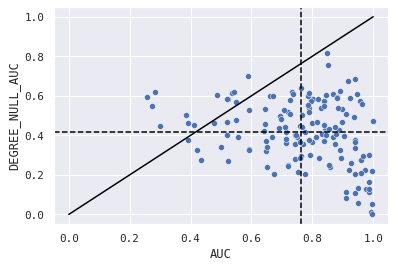

In [67]:
df_2d_jac, go_chrom  = run_egad(df_exp_clust, df_hic_corr)
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
auc_GO_terms_manw_three_list_hic_exp = []
for resolution in [100]:
    if species == 'drosophila':
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/1kbp_raw/max/inter_only/'
    else:
        fpath = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/{resolution}kbp_raw/max/'
    for fname in ['hic_gene_corr_inter_excluding_intra_nanranked_ind_1_percent_per_chr.csv']:
        
        df = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)

        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])

        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])


        #df_hic_auc = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/aggregates/10kbp_raw/max/inter_only/hic_gene_KR_inter_10_percent_per_chr_mouse_aggregates.csv', sep='\t')

        #df_hic_auc = pd.read_csv(f'{fpath}/{fname}', sep='\t')
        
        df_hic_auc = df_max_gene_inter_by_bins_cre


        go_df_scores = go_table.merge(df_hic_auc, left_on=go_table.index, right_on='gene_id_jac_sim')
        GO_groups = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther.txt', sep=" ", names=["del","go_id"])
        GO_groups_des = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_description.txt', sep=":", names=["del","des"])
        GO_groups_ben = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/aug4.GOslim', names=["go_id"])
        GO_groups_type = pd.read_csv('/grid/gillis/home/lohia/notebooks_proj2_marker_v2/goslim_panther_process.txt', sep=" ", names=["del","type"])




        from scipy.stats import mannwhitneyu
        import scipy.stats as stats
        z_list = []
        z_p_dict = []
        des_list = []
        for go_id in GO_groups["go_id"].tolist():
            
         if go_id in GO_groups_ben["go_id"].tolist():

            try:

                    t_p_scores = go_df_scores[go_df_scores[go_id] ==1 ]['auc_cre'].tolist()

                    t_n_scores = go_df_scores[go_df_scores[go_id] ==0 ]['auc_cre'].tolist()
                


                    U1, p_val = mannwhitneyu(t_p_scores, t_n_scores, use_continuity=False, alternative='greater')
                    #nx, ny = len(t_p_scores), len(t_n_scores)
                    #N = nx + ny
                    #z = (U1 - nx*ny/2) / np.sqrt(nx*ny * (N + 1)/ 12)
                    #p = stats.norm.sf(z)
                    z_list.append(U1)
                    z_p_dict.append(p_val)

                    #print (p, p_val)
            except:
                print (go_id)
                z_list.append(np.nan)
                z_p_dict.append(np.nan)


        auc_GO_terms_manw = pd.DataFrame(list(zip(GO_groups["go_id"].tolist(),  z_p_dict , z_list, GO_groups_des['des'].tolist(), GO_groups_type['type'].tolist())), columns=['id', 'P_val_agg', 'U1_stat', 'des', 'type'])
        auc_GO_terms_manw['species'] = species
        auc_GO_terms_manw.dropna(subset=['P_val_agg'], inplace=True)
        p_val_adjusted = sm.stats.multipletests(auc_GO_terms_manw['P_val_agg'].values, method='fdr_bh')
        auc_GO_terms_manw['adjusted_P_val_agg'] = p_val_adjusted[1]
        auc_GO_terms_manw.to_csv(f'{fpath}/GO_{fname}', sep='\t', index=False)
        auc_GO_terms_manw_three_list_hic_exp.append(auc_GO_terms_manw)


In [46]:
df_2d_jac.shape

(27, 4)

(24243, 24243)
(24243, 102)
0.990524452985418
0.0


<ipython-input-2-245e0933ef6b>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


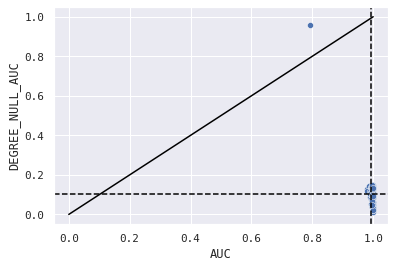

In [13]:
df_2d_jac, go_chrom  = run_egad(df_exp_clust, df_exp_corr)
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

(23465, 23465)
(23465, 254)
0.9995255121130314
3.632359968364085e-09


<ipython-input-49-87b5e6212035>:133: RuntimeWarning: invalid value encountered in true_divide
  roc = (p / n_p - (n_p + 1) / 2) / n_n
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


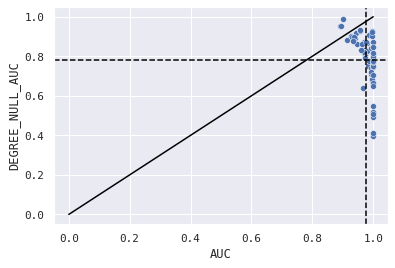

In [52]:
df_2d_jac, go_chrom  = run_egad(df_exp_clust, df_hic_corr)
import matplotlib.pyplot as plt
sns.scatterplot(df_2d_jac['AUC'], df_2d_jac['DEGREE_NULL_AUC'])
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [17]:
df_t = df_2d_jac.merge(df_exp_clust.sum().reset_index(), left_on=df_2d_jac.index, right_on='index')


In [20]:
df_t['quintile'] = pd.qcut(df_t[0] , 5, labels=np.arange(5, 0, -1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='quintile', ylabel='AUC'>

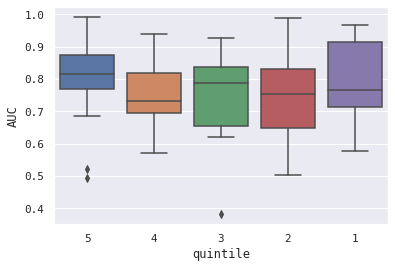

In [21]:
sns.boxplot(df_t['quintile'], df_t['AUC'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


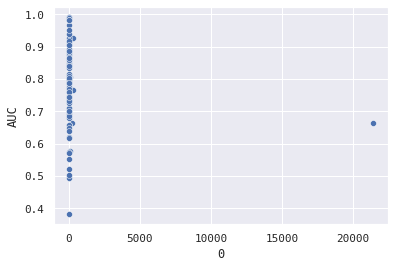

In [30]:
ax = sns.scatterplot(df_t[0], df_t['AUC'])
#ax.set_xlim([0,100])
#ax.set_ylim([0,1])

In [1]:
l

NameError: name 'l' is not defined